In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import time 
import seaborn as sns
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [4]:
class Net(nn.Module):
    # define nn
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 3)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, X):
        X = F.relu(self.fc1(X))
        X = self.fc2(X)
        X = self.fc3(X)
        X = self.softmax(X)

        return X

In [5]:

# load IRIS dataset
dataset = pd.read_csv('/share/u/rohit/eigens/pytorch-iris/dataset/iris.csv')

# transform species to numerics
dataset.loc[dataset.species=='Iris-setosa', 'species'] = 0
dataset.loc[dataset.species=='Iris-versicolor', 'species'] = 1
dataset.loc[dataset.species=='Iris-virginica', 'species'] = 2


train_X, test_X, train_y, test_y = train_test_split(dataset[dataset.columns[0:4]].values,
                                                    dataset.species.values, test_size=0.001)

# wrap up with Variable in pytorch
train_X = Variable(torch.Tensor(train_X).float())
test_X = Variable(torch.Tensor(test_X).float())
train_y = Variable(torch.Tensor(np.int16(train_y)).long())
test_y = Variable(torch.Tensor(np.int16(test_y)).long())


net = Net()

criterion = nn.CrossEntropyLoss()# cross entropy loss

optimizer = torch.optim.SGD(net.parameters(), lr=0.01)

In [6]:
dataset

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [7]:
for epoch in range(1000):
    optimizer.zero_grad()
    out = net(train_X)
    loss = criterion(out, train_y)
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print('number of epoch', epoch, 'loss', loss.item())


number of epoch 0 loss 1.110950231552124
number of epoch 100 loss 0.9214128255844116
number of epoch 200 loss 0.8257671594619751
number of epoch 300 loss 0.7730638384819031
number of epoch 400 loss 0.7326146960258484
number of epoch 500 loss 0.6998234987258911
number of epoch 600 loss 0.6746395826339722
number of epoch 700 loss 0.6559717655181885
number of epoch 800 loss 0.6422284841537476
number of epoch 900 loss 0.6319830417633057


In [6]:
predict_out = net(test_X)
_, predict_y = torch.max(predict_out, 1)

print('prediction accuracy', accuracy_score(test_y.data, predict_y.data))

print('macro precision', precision_score(test_y.data, predict_y.data, average='macro'))
print('micro precision', precision_score(test_y.data, predict_y.data, average='micro'))
print('macro recall', recall_score(test_y.data, predict_y.data, average='macro'))
print('micro recall', recall_score(test_y.data, predict_y.data, average='micro'))

prediction accuracy 1.0
macro precision 1.0
micro precision 1.0
macro recall 1.0
micro recall 1.0


## Get Eigen Vectors of a class of vectors

In [27]:
test_class = 0
samples_class = []
values_class = []
values_nonclass = []
samples_nonclass = []
for i in range(train_X.shape[0]):
    if int(train_y[i]) == test_class:
        samples_class.append(train_X[i])
        values_class.append(train_y[i])
    else:
        samples_nonclass.append(train_X[i])
        values_nonclass.append(train_y[i])
samples_class = torch.stack(samples_class)
samples_nonclass =torch.stack(samples_nonclass)
values_class = torch.stack(values_class)
values_nonclass = torch.stack(values_nonclass)

## Place hooks

In [28]:
view_output = []
def hook_fn(module, input, output):
    view_output.append(output)
    
view_output = []
hook = net.fc1.register_forward_hook(hook_fn)
out = net(train_X)
hook.remove()

In [29]:
mean_vector = view_output[0].mean(0)

In [30]:
view_output = []
def hook_fn(module, input, output):
    view_output.append(output)
    
view_output = []
hook = net.fc1.register_forward_hook(hook_fn)
out = net(samples_class)
hook.remove()

In [31]:
view_output[0].shape

torch.Size([50, 100])

In [32]:

view_output[0] = view_output[0] - view_output[0].mean(0)
    
torchtensor = view_output[0]

u,s,v = torch.svd(torchtensor.T)

top_eigens = 3
important_direction = u.T[:top_eigens]

In [33]:
u.shape

torch.Size([100, 50])

In [34]:
important_direction.shape

torch.Size([3, 100])

## Choose important eigen vector and remove the directions

In [35]:
from baukit import ImageFolderSet, show, renormalize, set_requires_grad, Trace, pbar, TraceDict
views = []
def remove_directions(output,layer):
    print(output)
    output_dup = output.detach().clone()
    for i in range(top_eigens):
        for j in range(output.shape[0]):
            magnitude = torch.norm(important_direction[i])
            dot = torch.dot(output_dup[j], important_direction[i])
            dot = dot/magnitude
            mean_dot = torch.dot(mean_vector, important_direction[i])
            mean_dot = mean_dot/magnitude
            
            output_dup[j] = output_dup[j] - important_direction[i]*dot + important_direction[i]*mean_dot
    print(output_dup)
    views.append(output_dup)
    return output_dup
views = []   
with Trace(net, 'fc1', edit_output=remove_directions) as tr:
    out = net(samples_class)
_, predict_y = torch.max(out, 1)

tensor([[-0.9986,  0.9067, -0.1441,  ...,  0.5806, -3.4139,  2.9508],
        [-1.0520,  0.9389, -0.0851,  ...,  0.5795, -3.3951,  2.9022],
        [-1.0169,  0.6505, -0.2459,  ...,  0.5866, -3.0801,  2.8000],
        ...,
        [-1.2872,  0.7234, -0.0494,  ...,  0.2939, -3.3796,  3.0292],
        [-1.3280,  0.6762, -0.1923,  ...,  0.4161, -3.6989,  3.3728],
        [-1.0837,  0.8460, -0.0572,  ...,  0.3847, -3.2906,  2.8708]],
       grad_fn=<AddmmBackward0>)
tensor([[-0.7562,  2.2408,  0.7523,  ...,  0.4169, -3.7357,  2.3403],
        [-0.7998,  2.2497,  0.7670,  ...,  0.4530, -3.7518,  2.3429],
        [-0.7894,  2.2476,  0.7635,  ...,  0.4444, -3.7480,  2.3423],
        ...,
        [-0.7469,  2.2389,  0.7491,  ...,  0.4091, -3.7323,  2.3398],
        [-0.7500,  2.2395,  0.7501,  ...,  0.4117, -3.7334,  2.3399],
        [-0.7202,  2.2334,  0.7401,  ...,  0.3870, -3.7224,  2.3382]],
       grad_fn=<CopySlices>)


In [36]:
predict_y

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1])

In [37]:
(predict_y == values_class).sum()/len(values_class)

tensor(0.)

In [38]:
out = net(samples_class)
_, predict_y = torch.max(out, 1)
predict_y

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])

In [39]:
(predict_y == values_class).sum()/len(values_class)

tensor(1.)

In [40]:
values_class

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])

In [41]:
views = []
with Trace(net, 'fc2', edit_output=remove_directions) as tr:
    out = net(samples_nonclass)
_, predict_y = torch.max(out, 1)
predict_y

tensor([[ 0.6700,  0.5241, -1.2133,  ..., -4.4974, -1.1160,  0.5597],
        [ 0.7239,  0.5501, -0.7007,  ..., -3.5316, -0.6695,  0.2699],
        [ 0.2158,  0.1716, -0.8858,  ..., -3.3335, -0.9166,  0.5502],
        ...,
        [ 0.8836,  0.6903, -0.9761,  ..., -4.0440, -0.9668,  0.3094],
        [ 0.1390,  0.1939, -1.0317,  ..., -3.4573, -1.1464,  0.6298],
        [-0.1633, -0.1429, -0.9172,  ..., -3.2386, -0.9040,  0.7801]],
       grad_fn=<AddmmBackward0>)
tensor([[ 0.2736,  2.1885, -0.8290,  ..., -4.0766, -4.7256,  2.9004],
        [ 0.3116,  2.2935, -0.2624,  ..., -3.1287, -4.3580,  2.6312],
        [-0.2098,  1.9690, -0.4019,  ..., -2.9529, -4.6430,  2.9097],
        ...,
        [ 0.4698,  2.3543, -0.5871,  ..., -3.6326, -4.6000,  2.6723],
        [-0.2906,  1.9692, -0.5602,  ..., -3.0767, -4.8615,  2.9936],
        [-0.5816,  1.7202, -0.3919,  ..., -2.8643, -4.6622,  3.1249]],
       grad_fn=<CopySlices>)


tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2,
        2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 1, 2,
        1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2,
        2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1,
        2, 2, 1])

In [42]:
(predict_y == values_nonclass).sum()/len(values_nonclass)

tensor(0.7677)

In [43]:
out = net(samples_nonclass)
_, predict_y = torch.max(out, 1)
predict_y

tensor([2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1,
        1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2,
        1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 1,
        2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1,
        2, 1, 1])

In [44]:
(predict_y == values_nonclass).sum()/len(values_nonclass)

tensor(0.9596)

In [45]:
values_nonclass

tensor([2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1,
        1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2,
        1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 1,
        2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1,
        2, 1, 1])

In [8]:
methods = ['Original','Original','Original', 'Deleting Virginia','Deleting Virginia','Deleting Virginia', 'Deleting Setosa','Deleting Setosa','Deleting Setosa', 'Deleting Versicolor', 'Deleting Versicolor', 'Deleting Versicolor']
classes = ['Setosa','Versicolor','Virginica','Setosa','Versicolor','Virginica','Setosa','Versicolor','Virginica','Setosa','Versicolor','Virginica' ]
accuracies = [0.98, .93, 1.0, 0.899, .87, 0.01, 0.03, .76, .83, .89, .1, .79]
# = [0.98, 0.899, 0.0, 0.89]
# class1 = [0.93, 0.87, 0.76, 0.1 ]
# class2 = [1.0, 0.0, 0.83, 0.79]

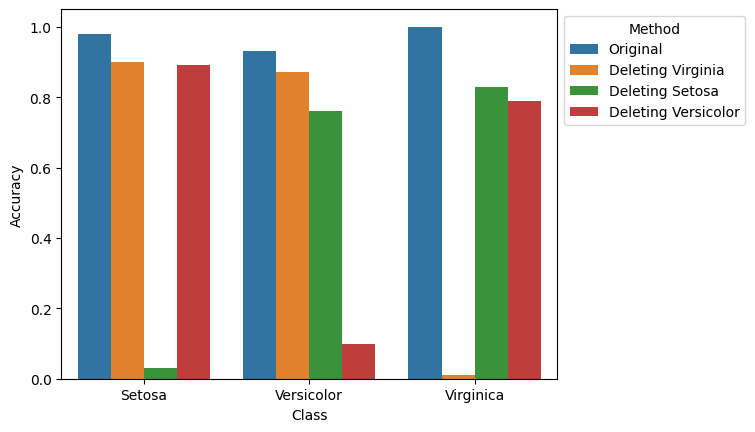

In [9]:
df = pd.DataFrame({'Method': methods, 'Class': classes, 'Accuracy': accuracies})

ax = sns.barplot(data=df, x='Class', y = 'Accuracy', hue= 'Method')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Visualizing the layer outputs

In [107]:
view_output = []
hook = net.fc2.register_forward_hook(hook_fn)
out = net(train_X)
hook.remove()

In [108]:
views = []
with Trace(net, 'fc2', edit_output=remove_directions) as tr:
    out = net(train_X)

tensor([[-0.7201, -0.0457,  0.4709,  ..., -1.5376,  0.5690,  0.2500],
        [-0.6180,  0.0094,  0.2072,  ..., -1.2868,  0.5127,  0.1058],
        [-0.5963, -0.1022,  0.5172,  ..., -1.0214,  0.3914,  0.2978],
        ...,
        [-0.7816, -0.1968,  0.7650,  ..., -1.2687,  0.3716,  0.4157],
        [-0.6325, -0.1038,  0.5490,  ..., -1.1498,  0.4312,  0.3403],
        [-0.3847,  0.1620, -0.1399,  ..., -1.2052,  0.5980, -0.1354]],
       grad_fn=<AddmmBackward0>)
tensor([[ 1.0228, -4.4091,  0.0301,  ..., -0.3780, -0.1578,  2.7923],
        [ 1.0532, -4.3405, -0.2471,  ..., -0.1665, -0.1972,  2.6083],
        [ 0.9693, -4.4857, -0.0120,  ...,  0.0517, -0.3123,  2.7860],
        ...,
        [ 0.8538, -4.5806,  0.2552,  ..., -0.1586, -0.3463,  2.9358],
        [ 0.9724, -4.4847,  0.0315,  ..., -0.0560, -0.2801,  2.8453],
        [ 1.2853, -4.1841, -0.5720,  ..., -0.0898, -0.1042,  2.3534]],
       grad_fn=<CopySlices>)


In [109]:
out = view_output[0]

In [110]:
out.shape

torch.Size([149, 100])

In [111]:
train_y.shape

torch.Size([149])

In [112]:
df = pd.DataFrame(out.detach().numpy())

In [113]:
data_subset = df.values

In [114]:
df['y'] = train_y.detach().numpy()

In [32]:
import time 
import seaborn as sns
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 135 samples in 0.000s...
[t-SNE] Computed neighbors for 135 samples in 0.067s...
[t-SNE] Computed conditional probabilities for sample 135 / 135
[t-SNE] Mean sigma: 1.533919
[t-SNE] KL divergence after 250 iterations with early exaggeration: 41.933811
[t-SNE] KL divergence after 300 iterations: 0.078548
t-SNE done! Time elapsed: 0.27696776390075684 seconds


In [33]:
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]

In [34]:
out_edited = views[0]

out_edited.shape

train_y.shape

df_edited = pd.DataFrame(out_edited.detach().numpy())

data_subset_edited = df_edited.values

df_edited['y'] = train_y.detach().numpy()

import time 
import seaborn as sns
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results_edited = tsne.fit_transform(data_subset_edited)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))


df_edited['tsne-2d-one'] = tsne_results_edited[:,0]
df_edited['tsne-2d-two'] = tsne_results_edited[:,1]

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 135 samples in 0.000s...
[t-SNE] Computed neighbors for 135 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 135 / 135
[t-SNE] Mean sigma: 1.518672
[t-SNE] KL divergence after 250 iterations with early exaggeration: 40.002762
[t-SNE] KL divergence after 300 iterations: 0.075020
t-SNE done! Time elapsed: 0.0599977970123291 seconds


<AxesSubplot: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

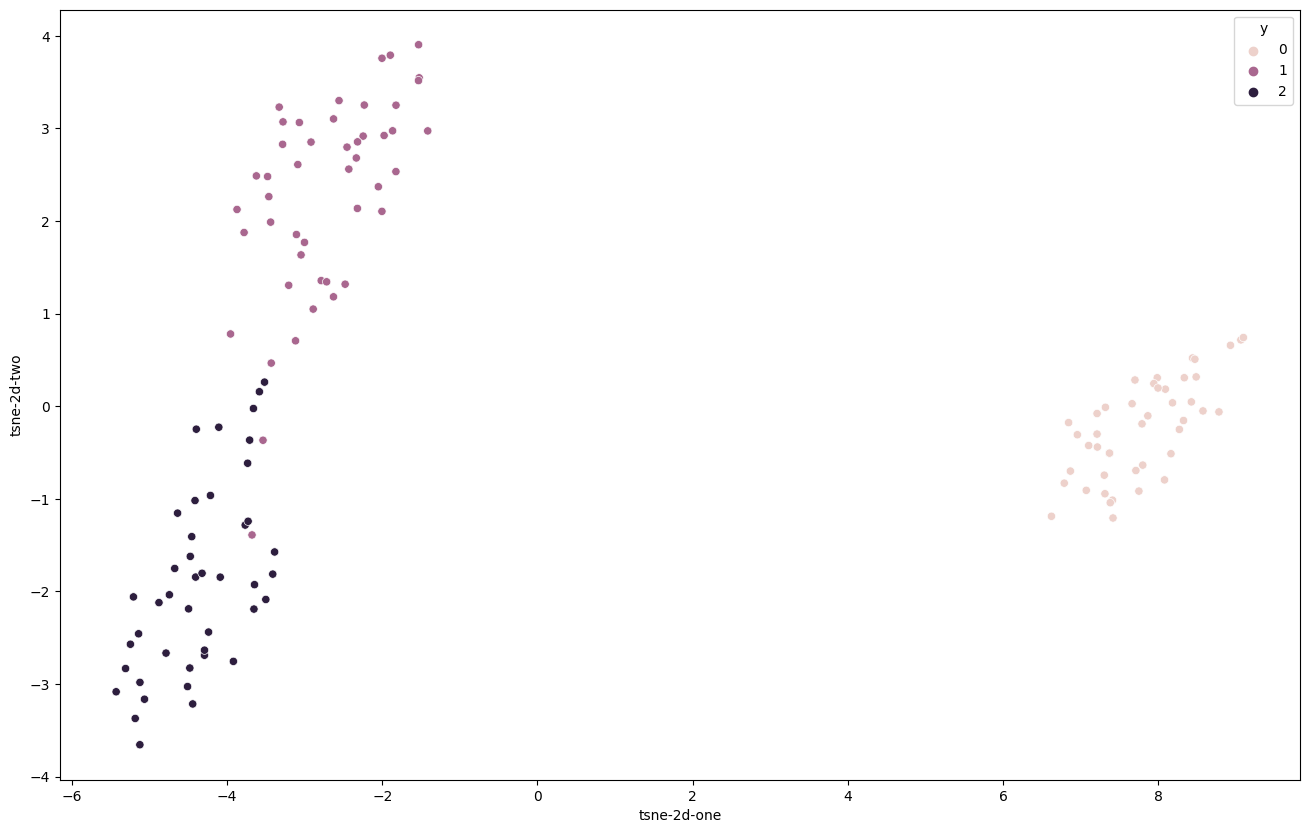

In [35]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
#     palette=sns.color_palette("hls", 10),
    data=df,
    legend="full",
#     alpha=0.3
)

<AxesSubplot: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

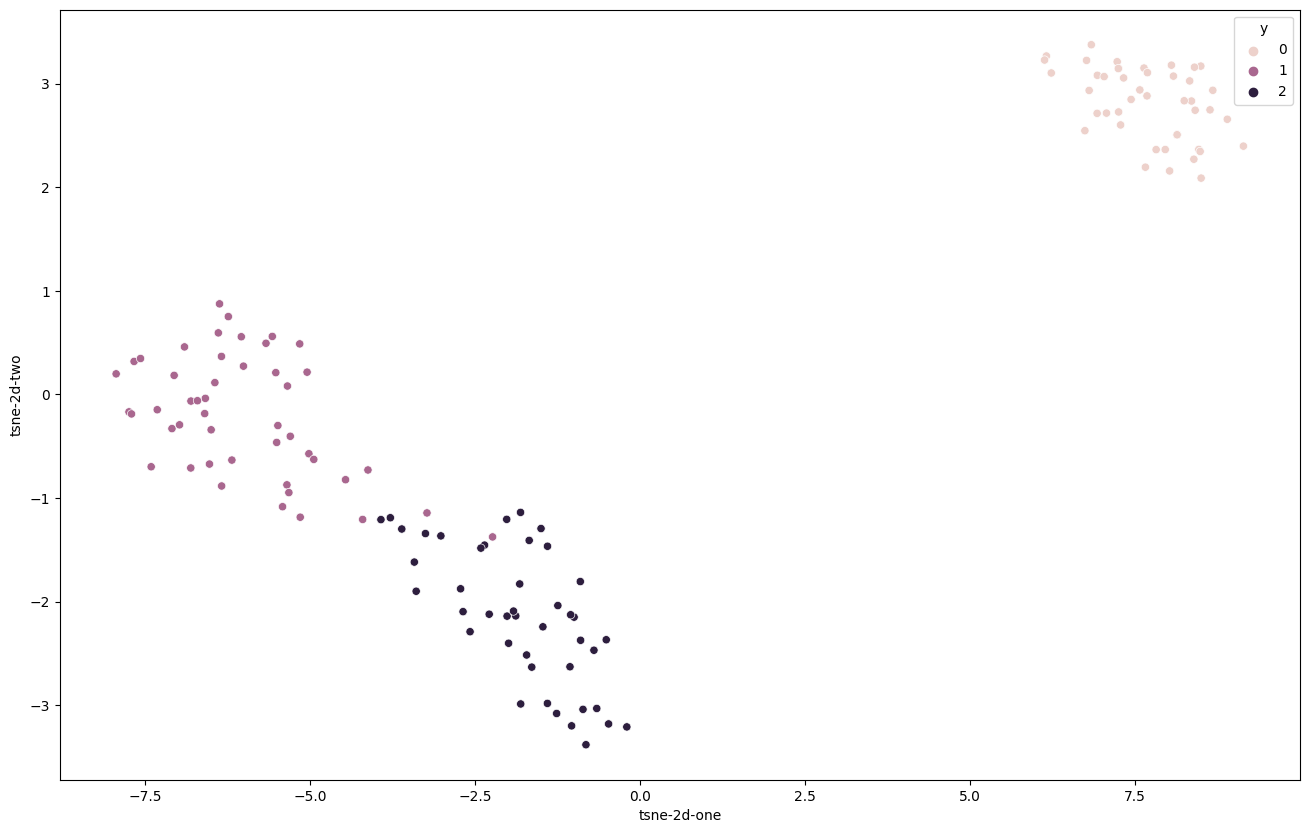

In [36]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
#     palette=sns.color_palette("hls", 10),
    data=df_edited,
    legend="full",
#     alpha=0.3
)

# Consolidating into a function

In [251]:
def eval_top_eigens(class_idx, top_eigens, train_X, train_y, layer='fc2', display=False, eigens = False):
    samples_class = []
    values_class = []
    values_nonclass = []
    samples_nonclass = []
    for i in range(train_X.shape[0]):
        if int(train_y[i]) == class_idx:
            samples_class.append(train_X[i])
            values_class.append(train_y[i])
        else:
            samples_nonclass.append(train_X[i])
            values_nonclass.append(train_y[i])
    samples_class = torch.stack(samples_class)
    samples_nonclass =torch.stack(samples_nonclass)
    values_class = torch.stack(values_class)
    values_nonclass = torch.stack(values_nonclass)

    ## Place hooks
    view_output = []
    def hook_fn(module, input, output):
        view_output.append(output)
    view_output = []
    if layer == 'fc2':
        hook = net.fc2.register_forward_hook(hook_fn)
    elif layer == 'fc1':
        hook = net.fc1.register_forward_hook(hook_fn)
    else:
        hook = net.fc3.register_forward_hook(hook_fn)
    out = net(samples_class)
    hook.remove()
    # SVD
    view_output[0] = view_output[0] - view_output[0].mean(0)
    torchtensor = view_output[0]
    u,s,v = torch.svd(torchtensor.T)
    important_direction = u.T[:top_eigens]
    
    ## Choose important eigen vector and remove the directions
    from baukit import ImageFolderSet, show, renormalize, set_requires_grad, Trace, pbar, TraceDict
    views = []
    def remove_directions(output,layer):
        if len(important_direction) == 0:
            return output
        output_dup = output.detach().clone()
        for i in range(top_eigens):
            for j in range(output.shape[0]):
                dot = torch.dot(output[j], important_direction[i])
                output_dup[j] = output_dup[j] - important_direction[i]*dot
        views.append(output_dup)
        return output_dup
    # Test accuracy before editing
    out = net(samples_class)
    _, predict_y = torch.max(out, 1)
    print(f'Accuracy of Class {class_idx} before edit: {(predict_y == values_class).sum()/len(values_class)}')
    # Test accuracy after editing
    views = []   
    with Trace(net, layer, edit_output=remove_directions) as tr:
        out = net(samples_class)
    _, predict_y = torch.max(out, 1)
    print(f'Accuracy of Class {class_idx} after edit: {(predict_y == values_class).sum()/len(values_class)}')
    # Test accuracy of non-class before edit
    out = net(samples_nonclass)
    _, predict_y = torch.max(out, 1)
    print(f'Accuracy of other classes before edit: {(predict_y == values_nonclass).sum()/len(values_nonclass)}')
    views = []
    with Trace(net, layer, edit_output=remove_directions) as tr:
        out = net(samples_nonclass)
    _, predict_y = torch.max(out, 1)
#     print(predict_y)
    print(f'Accuracy of other classes after edit: {(predict_y == values_nonclass).sum()/len(values_nonclass)}')
    if display:
        try:
            view_output = []
            if layer == 'fc2':
                hook = net.fc2.register_forward_hook(hook_fn)
            elif layer == 'fc1':
                hook = net.fc1.register_forward_hook(hook_fn)
            else:
                hook = net.fc3.register_forward_hook(hook_fn)
            out = net(train_X)
            hook.remove()
            out = view_output[0]

            df = pd.DataFrame(out.detach().numpy())

            data_subset = df.values
            df['y'] = train_y.detach().numpy()

            tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
            tsne_results = tsne.fit_transform(data_subset)

            df['tsne-2d-one'] = tsne_results[:,0]
            df['tsne-2d-two'] = tsne_results[:,1]

            views = []
            with Trace(net, layer, edit_output=remove_directions) as tr:
                out = net(train_X)
            out_edited = views[0]
            df_edited = pd.DataFrame(out_edited.detach().numpy())
            data_subset_edited = df_edited.values
            df_edited['y'] = train_y.detach().numpy()
            tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
            tsne_results_edited = tsne.fit_transform(data_subset_edited)

            df_edited['tsne-2d-one'] = tsne_results_edited[:,0]
            df_edited['tsne-2d-two'] = tsne_results_edited[:,1]

            fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))

            ax1.set_title('TSNE before edit')
            sns.scatterplot(
                x="tsne-2d-one", y="tsne-2d-two",
                hue="y",
            #     palette=sns.color_palette("hls", 10),
                data=df,
                legend="full",
                ax = ax1
            #     alpha=0.3
            )
            sns.scatterplot(
                x="tsne-2d-one", y="tsne-2d-two",
                hue="y",
            #     palette=sns.color_palette("hls", 10),
                data=df_edited,
                legend="full",
            #     alpha=0.3
                ax = ax2
            )
            ax2.set_title('TSNE after edit')
            fig.suptitle(f'Removing Top {top_eigens} Eigen Direction of class {class_idx}')
            plt.show()
        except:
            pass
    if eigens:
        return important_direction
        

# Top Eigen vector

Accuracy of Class 2 before edit: 1.0
Accuracy of Class 2 after edit: 0.0
Accuracy of other classes before edit: 0.9595959782600403
Accuracy of other classes after edit: 0.49494948983192444


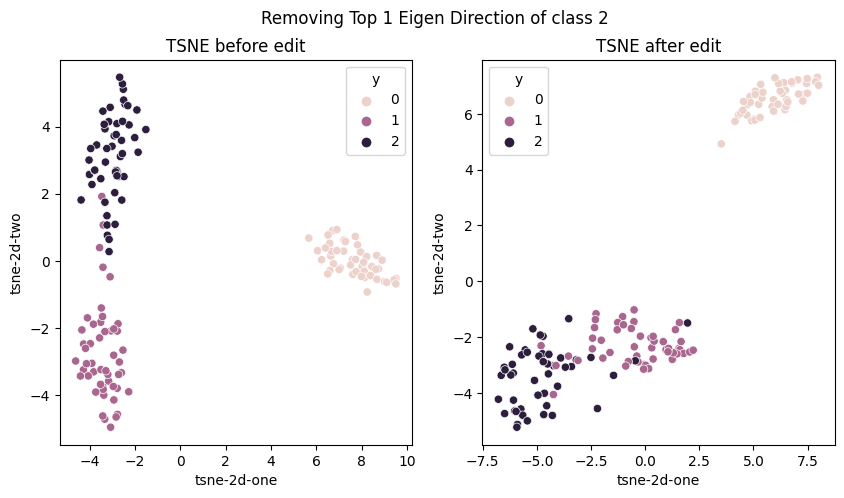

In [252]:
eval_top_eigens(class_idx=2, top_eigens=1, train_X=train_X, train_y=train_y, display=True)

Accuracy of Class 1 before edit: 0.9200000166893005
Accuracy of Class 1 after edit: 0.0
Accuracy of other classes before edit: 1.0
Accuracy of other classes after edit: 0.49494948983192444


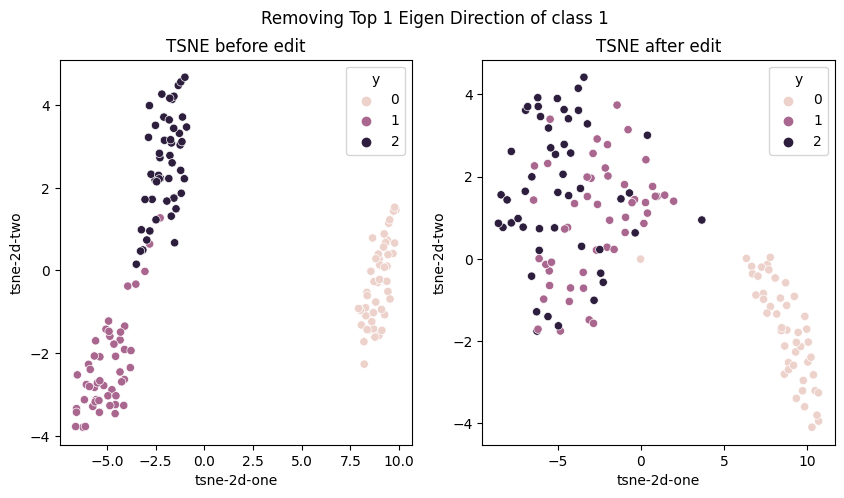

In [253]:
eval_top_eigens(class_idx=1, top_eigens=1, train_X=train_X, train_y=train_y, display=True)

Accuracy of Class 0 before edit: 1.0
Accuracy of Class 0 after edit: 0.0
Accuracy of other classes before edit: 0.9599999785423279
Accuracy of other classes after edit: 0.5299999713897705


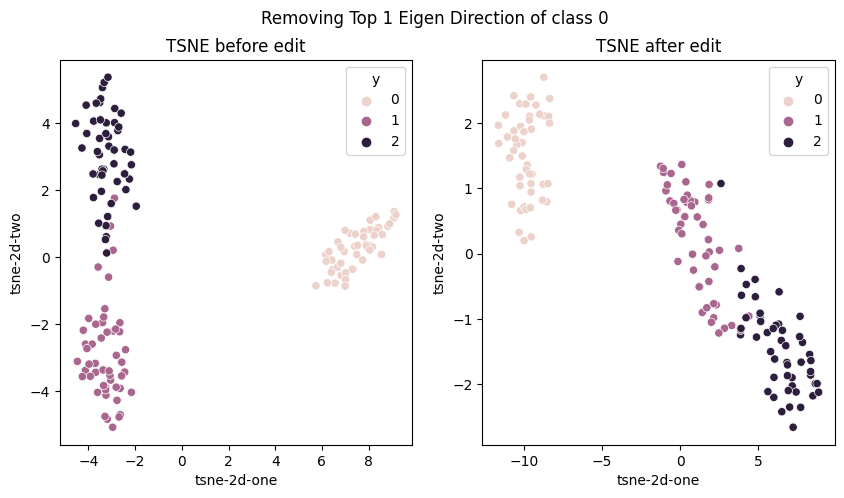

In [254]:
eval_top_eigens(class_idx=0, top_eigens=1, train_X=train_X, train_y=train_y, display=True)

# Top 2 Eigen vectors

Accuracy of Class 2 before edit: 1.0
Accuracy of Class 2 after edit: 0.3799999952316284
Accuracy of other classes before edit: 0.9595959782600403
Accuracy of other classes after edit: 0.49494948983192444


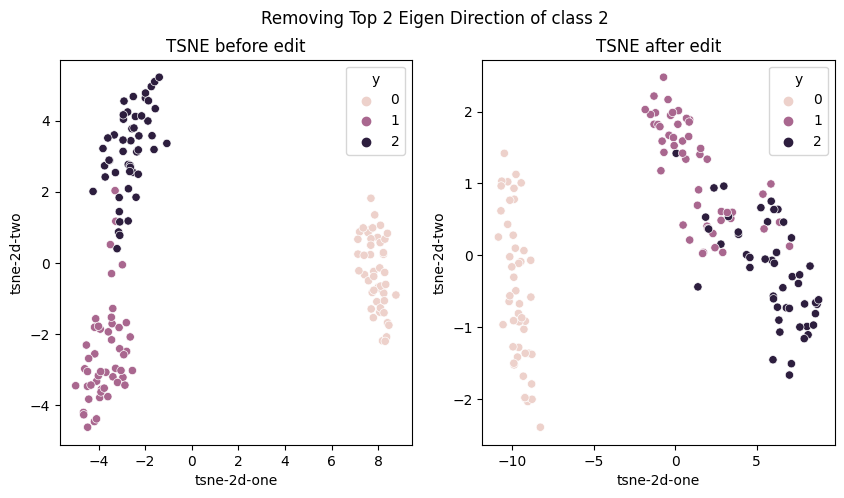

In [255]:
eval_top_eigens(class_idx=2, top_eigens=2, train_X=train_X, train_y=train_y, display=True)

Accuracy of Class 1 before edit: 0.9200000166893005
Accuracy of Class 1 after edit: 0.8199999928474426
Accuracy of other classes before edit: 1.0
Accuracy of other classes after edit: 0.49494948983192444


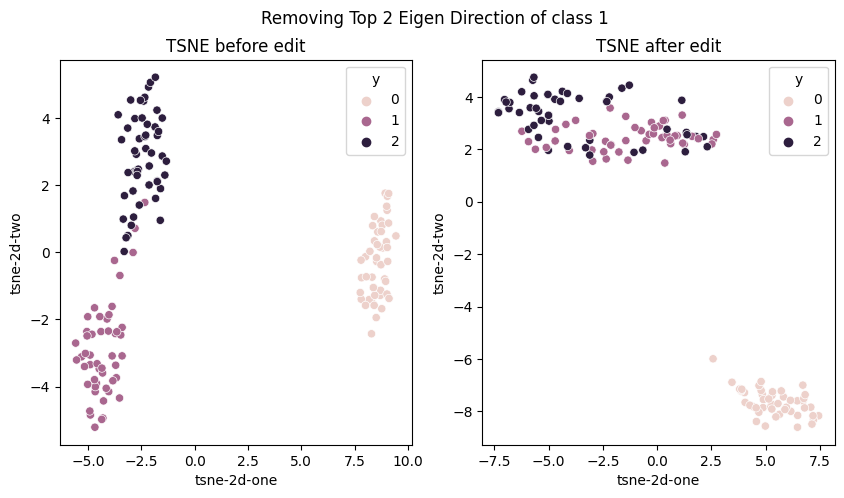

In [256]:
eval_top_eigens(class_idx=1, top_eigens=2, train_X=train_X, train_y=train_y, display=True)

Accuracy of Class 0 before edit: 1.0
Accuracy of Class 0 after edit: 0.0
Accuracy of other classes before edit: 0.9599999785423279
Accuracy of other classes after edit: 0.7699999809265137


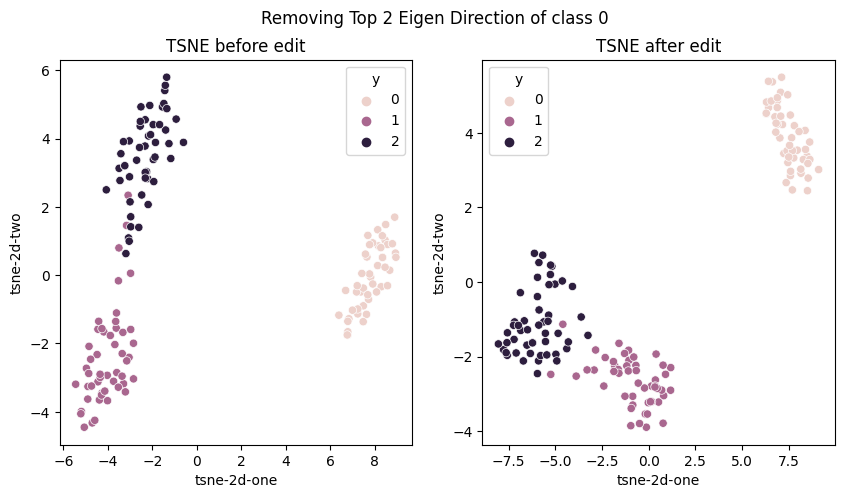

In [257]:
eval_top_eigens(class_idx=0, top_eigens=2, train_X=train_X, train_y=train_y, display=True)

# Top 3 Eigen vectors

Accuracy of Class 2 before edit: 1.0
Accuracy of Class 2 after edit: 0.0
Accuracy of other classes before edit: 0.9595959782600403
Accuracy of other classes after edit: 1.0


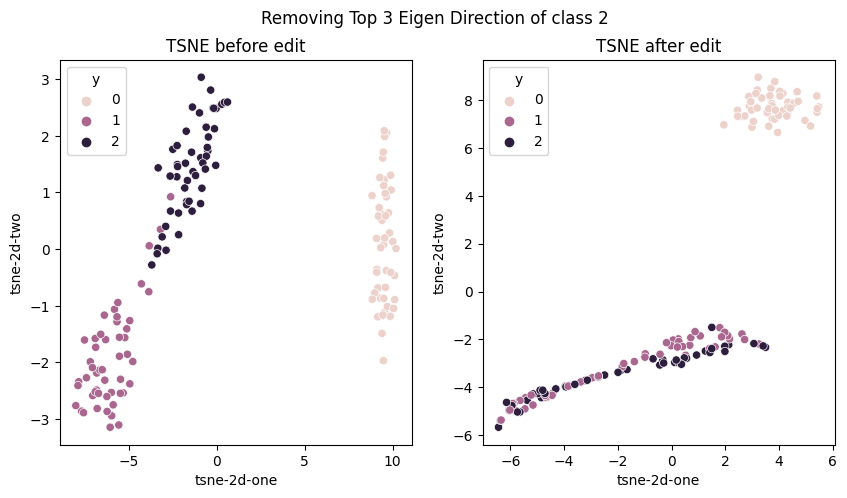

In [258]:
eval_top_eigens(class_idx=2, top_eigens=3, train_X=train_X, train_y=train_y, display=True)

Accuracy of Class 1 before edit: 0.9200000166893005
Accuracy of Class 1 after edit: 1.0
Accuracy of other classes before edit: 1.0
Accuracy of other classes after edit: 0.49494948983192444


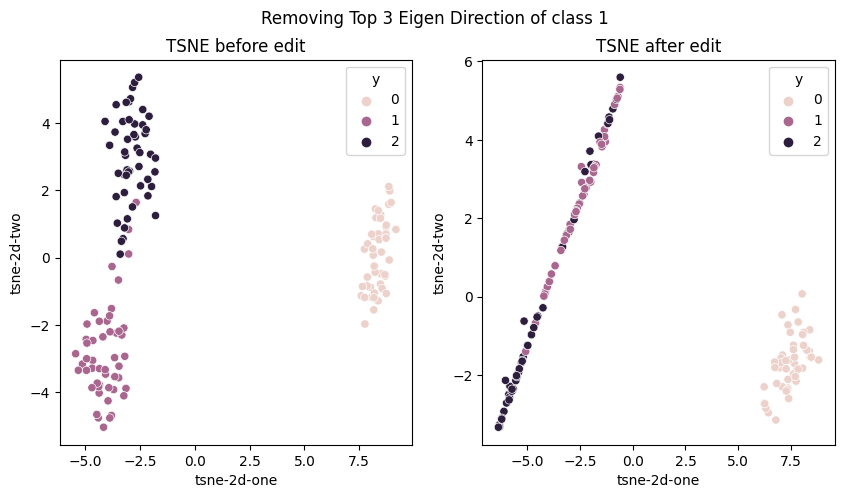

In [259]:
eval_top_eigens(class_idx=1, top_eigens=3, train_X=train_X, train_y=train_y, display=True)

Accuracy of Class 0 before edit: 1.0
Accuracy of Class 0 after edit: 0.9795918464660645
Accuracy of other classes before edit: 0.9599999785423279
Accuracy of other classes after edit: 0.9100000262260437


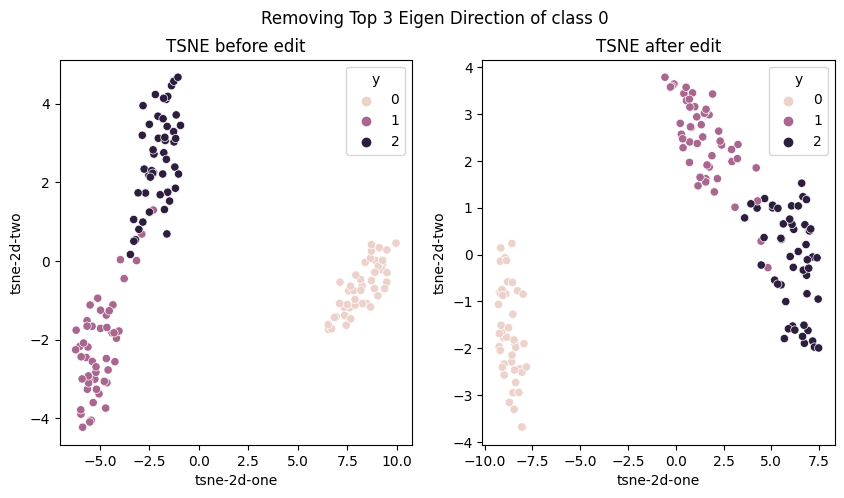

In [260]:
eval_top_eigens(class_idx=0, top_eigens=3, train_X=train_X, train_y=train_y, display=True)

# Top 4 Eigen vectors

Accuracy of Class 2 before edit: 1.0
Accuracy of Class 2 after edit: 0.0
Accuracy of other classes before edit: 0.9595959782600403
Accuracy of other classes after edit: 1.0


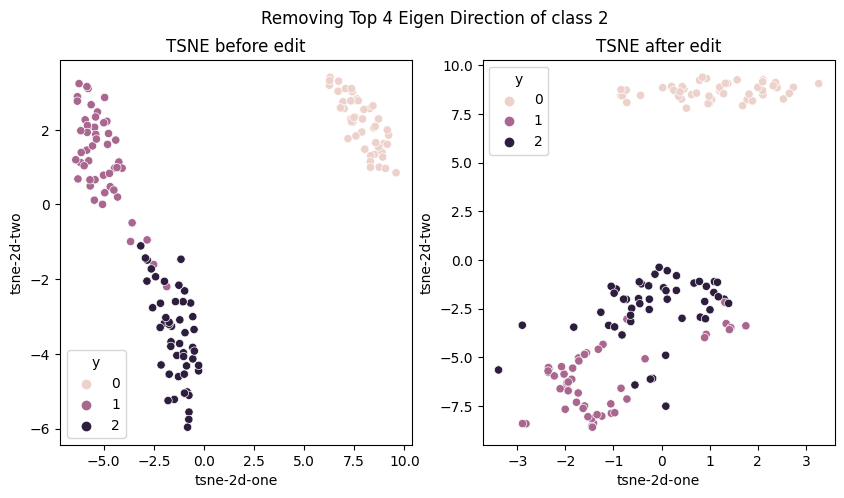

In [261]:
eval_top_eigens(class_idx=2, top_eigens=4, train_X=train_X, train_y=train_y, display=True)

Accuracy of Class 1 before edit: 0.9200000166893005
Accuracy of Class 1 after edit: 1.0
Accuracy of other classes before edit: 1.0
Accuracy of other classes after edit: 0.49494948983192444


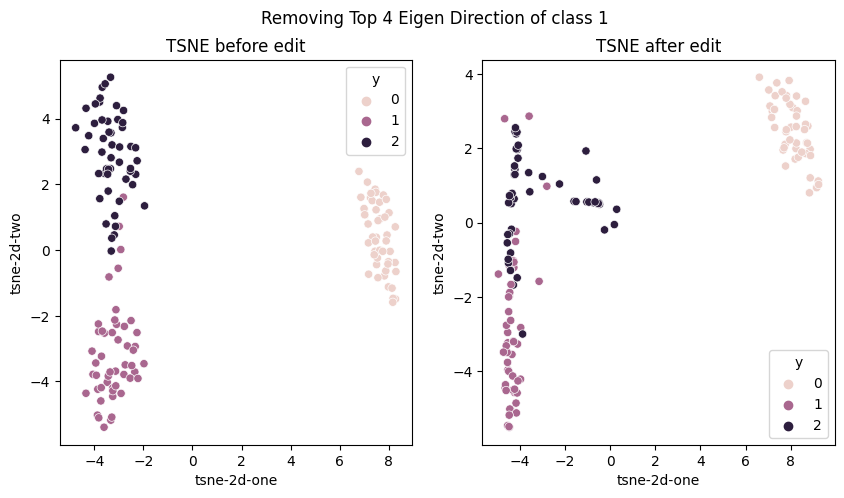

In [262]:
eval_top_eigens(class_idx=1, top_eigens=4, train_X=train_X, train_y=train_y, display=True)

Accuracy of Class 0 before edit: 1.0
Accuracy of Class 0 after edit: 1.0
Accuracy of other classes before edit: 0.9599999785423279
Accuracy of other classes after edit: 0.800000011920929


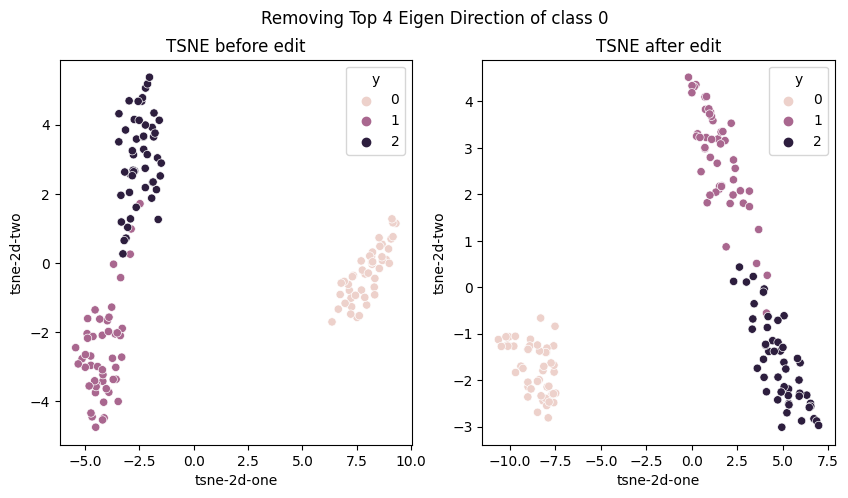

In [263]:
eval_top_eigens(class_idx=0, top_eigens=4, train_X=train_X, train_y=train_y, display=True)

# Top 20 Eigen vectors

Accuracy of Class 2 before edit: 1.0
Accuracy of Class 2 after edit: 0.0
Accuracy of other classes before edit: 0.9595959782600403
Accuracy of other classes after edit: 1.0


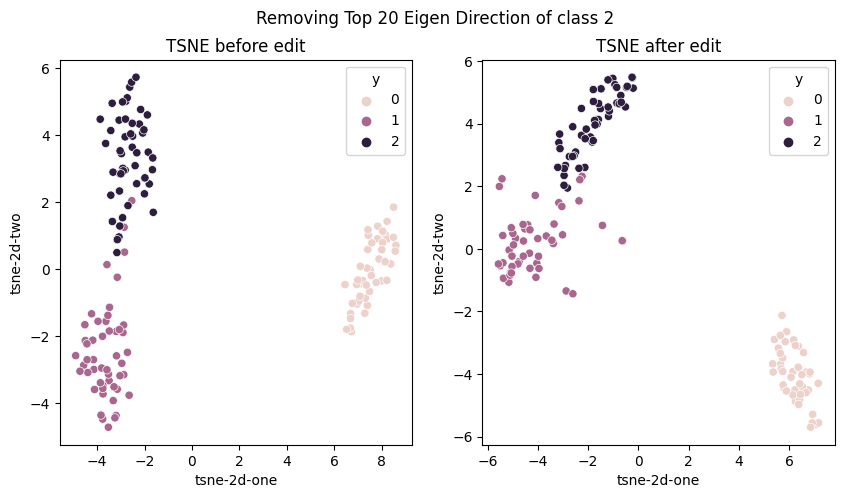

In [264]:
eval_top_eigens(class_idx=2, top_eigens=20, train_X=train_X, train_y=train_y, display=True)

Accuracy of Class 1 before edit: 0.9200000166893005
Accuracy of Class 1 after edit: 1.0
Accuracy of other classes before edit: 1.0
Accuracy of other classes after edit: 0.4848484992980957


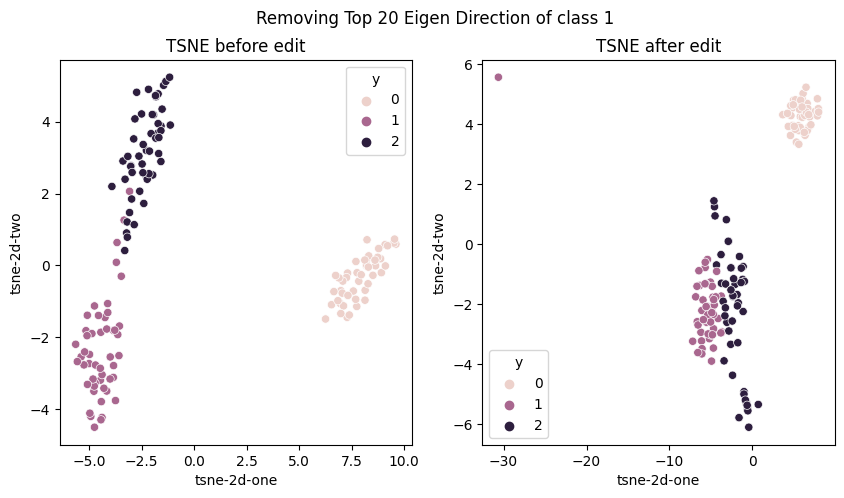

In [265]:
eval_top_eigens(class_idx=1, top_eigens=20, train_X=train_X, train_y=train_y, display=True)

Accuracy of Class 0 before edit: 1.0
Accuracy of Class 0 after edit: 1.0
Accuracy of other classes before edit: 0.9599999785423279
Accuracy of other classes after edit: 0.23000000417232513


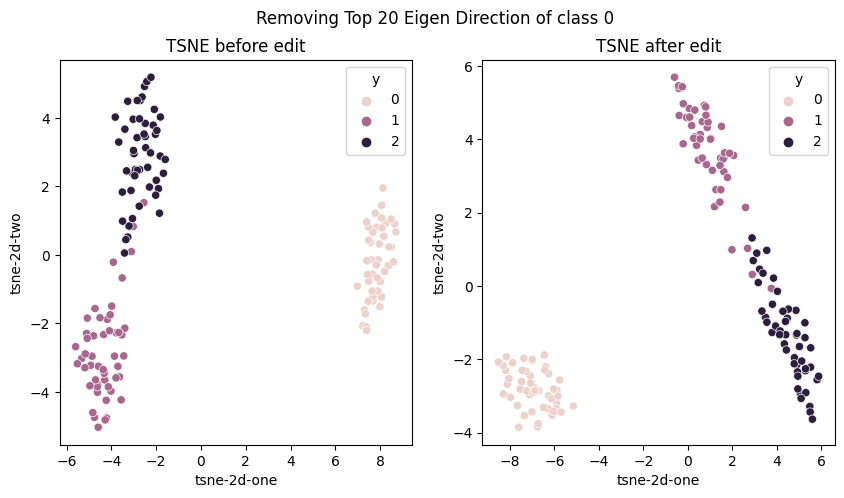

In [266]:
eval_top_eigens(class_idx=0, top_eigens=20, train_X=train_X, train_y=train_y, display=True)

# Cross checking with network weights

In [197]:
for name, param in net.named_parameters():
    if name == 'fc3.weight':
        weight = param
    if name == 'fc3.bias':
        bias = param

idx = 0
eigen_direction = eval_top_eigens(class_idx=idx, top_eigens=20, train_X=train_X, train_y=train_y, display=False, eigens=True)
weights = weight[idx]/torch.norm(weight[idx])
print('----------------------------------------------------------')
for i in range(5):
    print(f'Dot product of Eigen {i+1} and weight: {torch.dot(weights, eigen_direction[i])}')
    print(f'Dot product of Eigen {i+1} and weight+bias: {torch.dot(weights, eigen_direction[i])+bias[idx]}')
    print('\n')

Accuracy of Class 0 before edit: 1.0
Accuracy of Class 0 after edit: 0.0
Accuracy of other classes before edit: 0.9444444179534912
Accuracy of other classes after edit: 0.8777777552604675
----------------------------------------------------------
Dot product of Eigen 1 and weight: 0.02875753492116928
Dot product of Eigen 1 and weight+bias: 0.09649740159511566


Dot product of Eigen 2 and weight: -0.08299356698989868
Dot product of Eigen 2 and weight+bias: -0.015253700315952301


Dot product of Eigen 3 and weight: 0.012798774987459183
Dot product of Eigen 3 and weight+bias: 0.08053864538669586


Dot product of Eigen 4 and weight: -0.0965179055929184
Dot product of Eigen 4 and weight+bias: -0.028778038918972015


Dot product of Eigen 5 and weight: 0.07608301937580109
Dot product of Eigen 5 and weight+bias: 0.14382287859916687




In [198]:
idx = 1
eigen_direction = eval_top_eigens(class_idx=idx, top_eigens=20, train_X=train_X, train_y=train_y, display=False, eigens=True)
weights = weight[idx]/torch.norm(weight[idx])
print('----------------------------------------------------------')
for i in range(5):
    print(f'Dot product of Eigen {i+1} and weight: {torch.dot(weights, eigen_direction[i])}')
    print(f'Dot product of Eigen {i+1} and weight+bias: {torch.dot(weights, eigen_direction[i])+bias[idx]}')
    print('\n')

Accuracy of Class 1 before edit: 0.914893627166748
Accuracy of Class 1 after edit: 0.0
Accuracy of other classes before edit: 0.9886363744735718
Accuracy of other classes after edit: 1.0
----------------------------------------------------------
Dot product of Eigen 1 and weight: 0.20908591151237488
Dot product of Eigen 1 and weight+bias: 0.3433202803134918


Dot product of Eigen 2 and weight: -0.01919838786125183
Dot product of Eigen 2 and weight+bias: 0.11503598093986511


Dot product of Eigen 3 and weight: -0.017174936830997467
Dot product of Eigen 3 and weight+bias: 0.11705943197011948


Dot product of Eigen 4 and weight: -0.12334249913692474
Dot product of Eigen 4 and weight+bias: 0.0108918696641922


Dot product of Eigen 5 and weight: -0.08923451602458954
Dot product of Eigen 5 and weight+bias: 0.044999852776527405




In [199]:
idx = 2
eigen_direction = eval_top_eigens(class_idx=idx, top_eigens=20, train_X=train_X, train_y=train_y, display=False, eigens=True)
weights = weight[idx]/torch.norm(weight[idx])
print('----------------------------------------------------------')
for i in range(5):
    print(f'Dot product of Eigen {i+1} and weight: {torch.dot(weights, eigen_direction[i])}')
    print(f'Dot product of Eigen {i+1} and weight+bias: {torch.dot(weights, eigen_direction[i])+bias[idx]}')
    print('\n')

Accuracy of Class 2 before edit: 0.9767441749572754
Accuracy of Class 2 after edit: 0.0
Accuracy of other classes before edit: 0.95652174949646
Accuracy of other classes after edit: 1.0
----------------------------------------------------------
Dot product of Eigen 1 and weight: -0.07692186534404755
Dot product of Eigen 1 and weight+bias: -0.17079687118530273


Dot product of Eigen 2 and weight: 0.02934185415506363
Dot product of Eigen 2 and weight+bias: -0.06453315168619156


Dot product of Eigen 3 and weight: 0.04649816080927849
Dot product of Eigen 3 and weight+bias: -0.0473768450319767


Dot product of Eigen 4 and weight: -0.15647640824317932
Dot product of Eigen 4 and weight+bias: -0.2503514289855957


Dot product of Eigen 5 and weight: 0.12505678832530975
Dot product of Eigen 5 and weight+bias: 0.031181782484054565


